In [1]:
import sys, os, json
import numpy as np
import pandas as pd
import seaborn as sns
import argparse, progressbar
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.axes import Axes

In [2]:
# read files and prepare the datasets
data_dir = r"C:\GoogleDrive\GitHub\deep_learning\misc\misc\apu_research"
df_li = pd.read_csv(f"{data_dir}/summary_stats_sovi_svi_LI_dynamic0711.csv")
df_nli = pd.read_csv(f"{data_dir}/summary_stats_sovi_svi_NLI_dynamic0711.csv")
df_li["LI"] = "Low Income"
df_nli["LI"] = "not-Low Income"
df_li_nli = pd.concat([df_li, df_nli], ignore_index=True)

In [3]:
from matplotlib.lines import Line2D

custom_legend = []
markers = {
    'GLF_Low Income': 'o',
    'MDA_Low Income': 's',
    'SE_Low Income': 'D',
    'GLF_not-Low Income': '^',
    'MDA_not-Low Income': 'v',
    'NE_not-Low Income': 'P',
    'NW_not-Low Income': 'X',
    'SE_not-Low Income': '*',
    'SW_not-Low Income': '<',
}

for mk, mv in markers.items():
    legend_line = Line2D([0], [0],
                         marker=markers[mk],
                         color="w",
                         markerfacecolor="black",
                         markersize=8,
                         label=mk)
    custom_legend.append(legend_line)


''

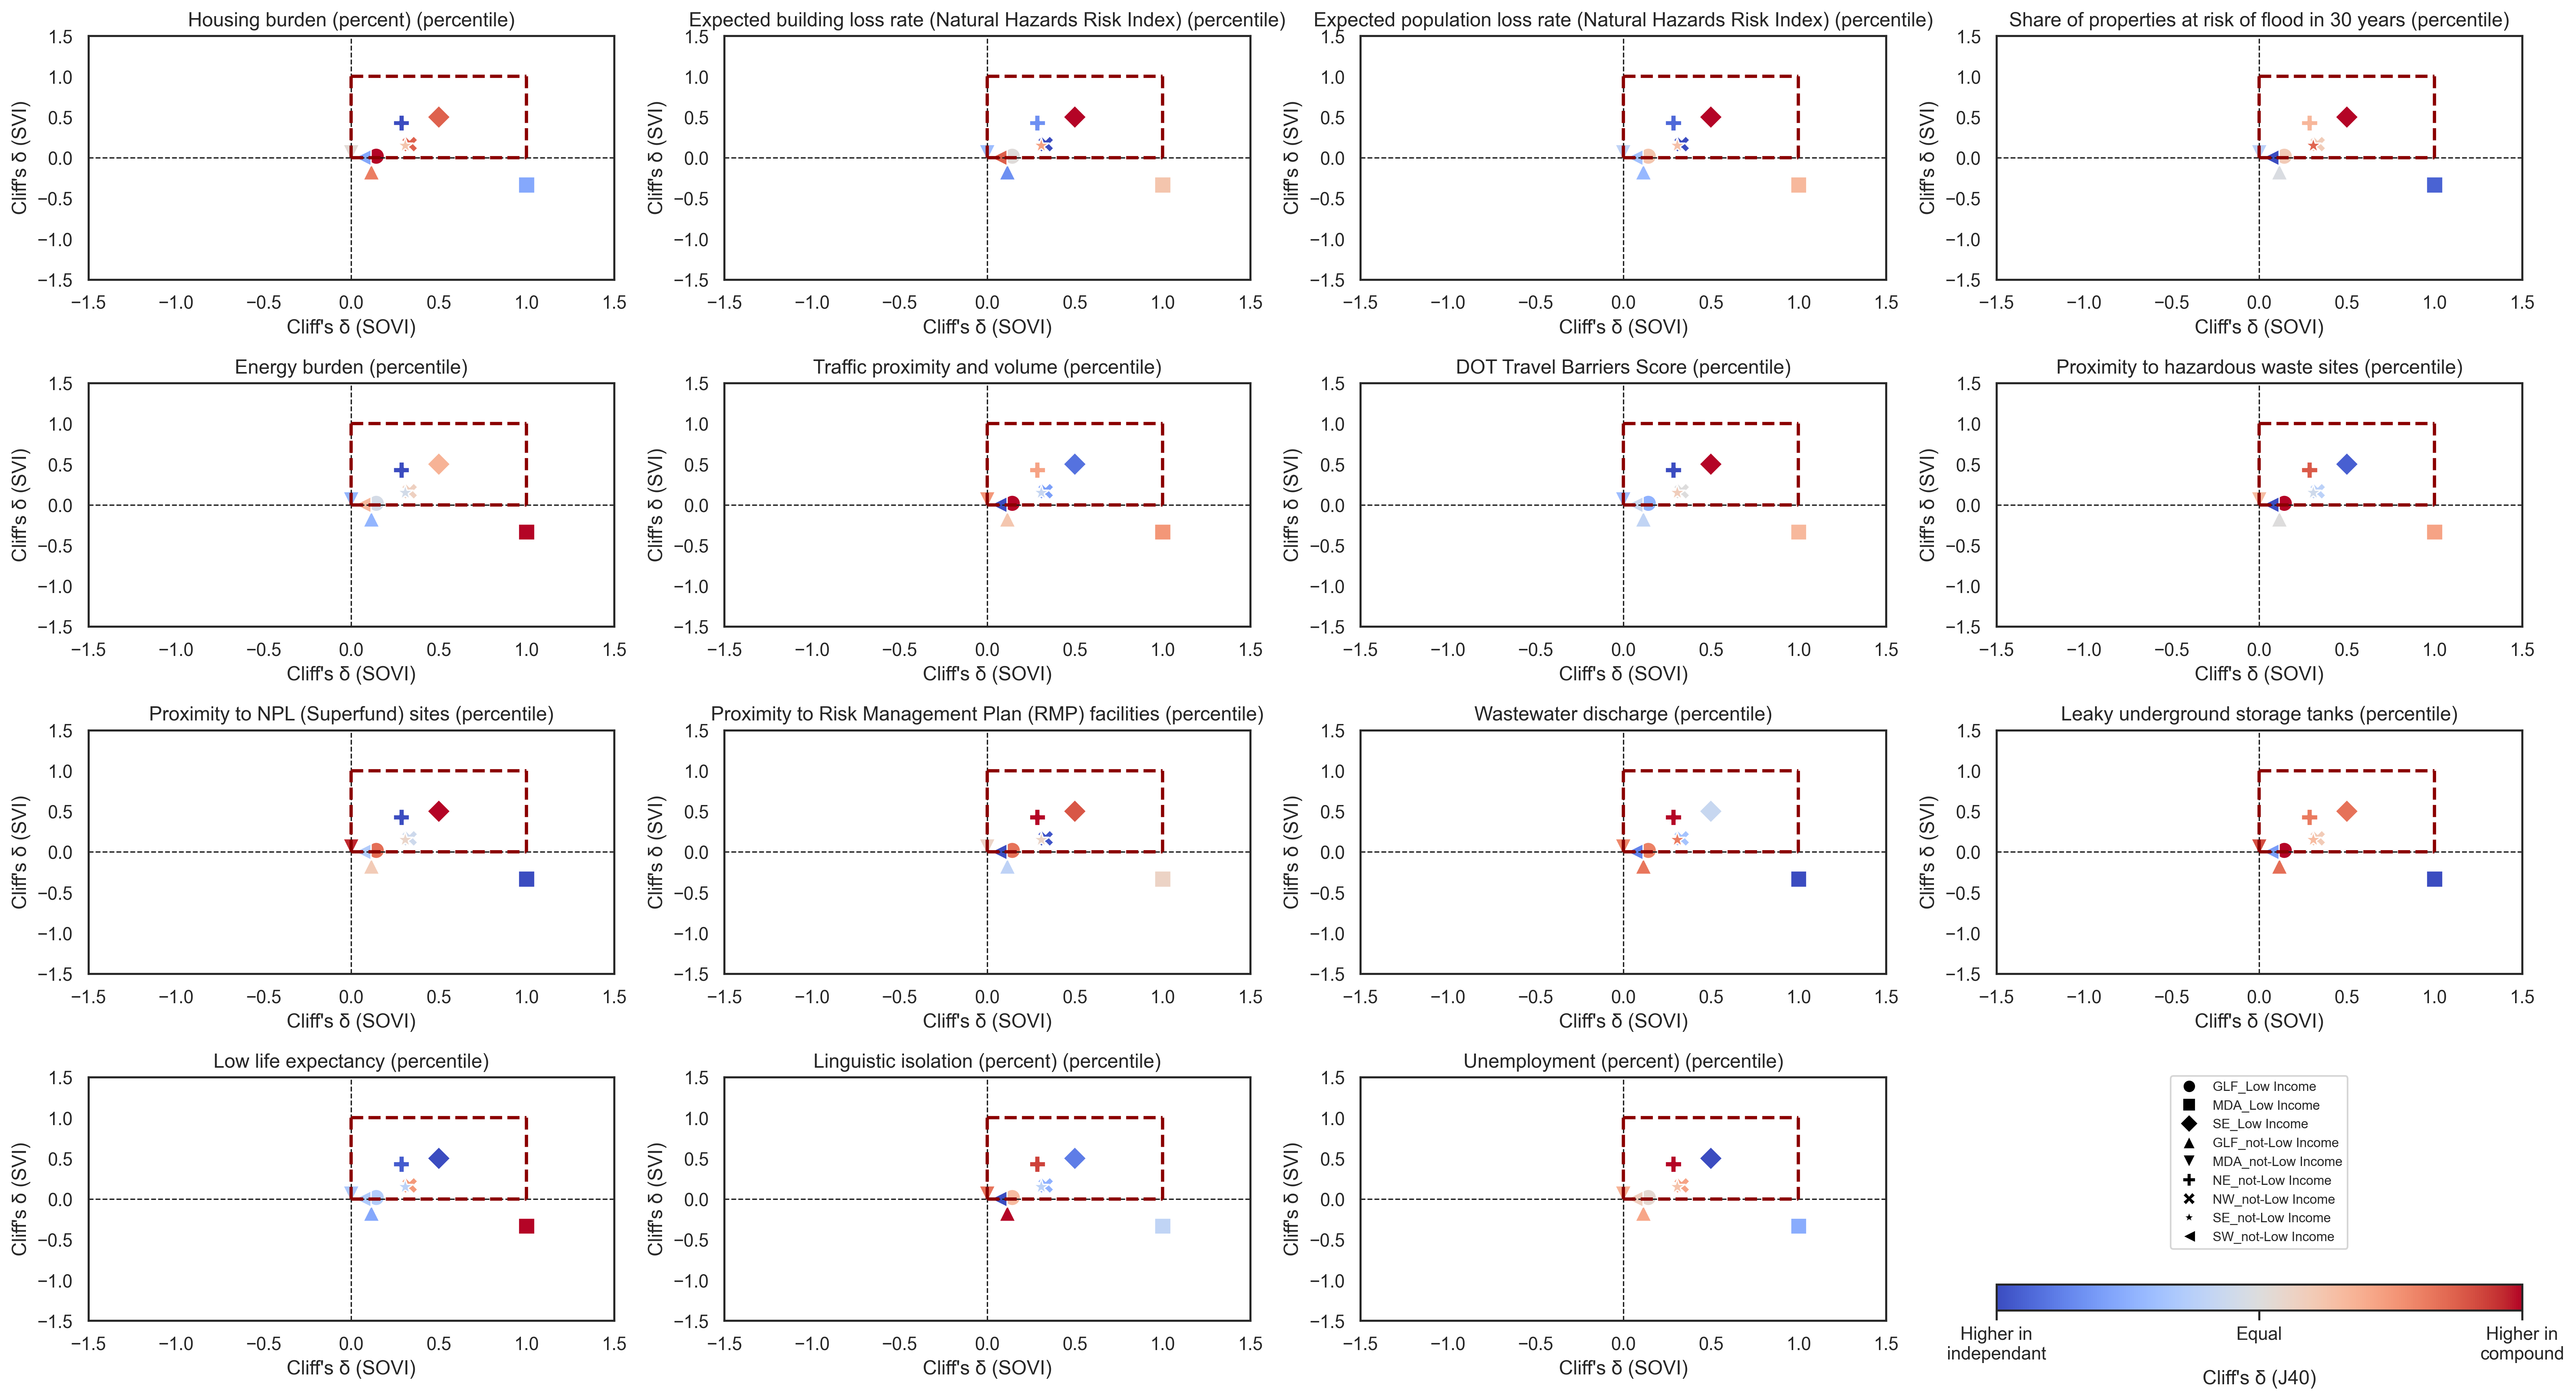

In [4]:
unique_source = df_li_nli.query("Source != 'SOVI' and Source != 'SVI'")["Source"].unique()
unique_source = list(unique_source)

# init fig and axes objects
sns.set(font_scale=1)
sns.set_style("white")
nrows = 4
ncols = 4
fig_height = nrows * 3
fig_width = ncols * 5.5
f: Figure
ax: Axes
f, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fig_width, fig_height), dpi=300)
axes_flat = ax.flatten()
# %% ##################################################################
for row in range(nrows):
    for col in range(ncols):
        # extract data
        select_cols = ['LI', 'Cregion', 'cliff_d']
        sovi_x = df_li_nli.query("Source == 'SOVI'")[select_cols].drop_duplicates()
        svi_y = df_li_nli.query("Source == 'SVI'")[select_cols].drop_duplicates()

        if len(unique_source) > 0:
            dim_of_interest = unique_source.pop(0)
            z_dimension = (
                df_li_nli.query(f"Source == '{dim_of_interest}'")[select_cols].drop_duplicates())
            graph_df = pd.merge(sovi_x, svi_y,
                                how='inner',
                                on=['LI', 'Cregion'],
                                suffixes=('_x', '_y'))
            graph_df = pd.merge(graph_df, z_dimension, how='inner',
                                on=['LI', 'Cregion'],
                                suffixes=(None, '_z'))
            graph_df.columns = ['Li', 'Cregion', 'SOVI', 'SVI', 'J40']
            graph_df["Cregion_Li"] = graph_df["Cregion"] + "_" + graph_df["Li"]
            graph_df = graph_df.dropna()
            graph_df = graph_df.sort_values(by=['Li', 'Cregion']).reset_index(drop=True)

            # plotting starts here
            ax_ = sns.scatterplot(data=graph_df,
                                  x="SOVI",
                                  y="SVI",
                                  hue="J40",
                                  style="Cregion_Li",
                                  ax=ax[row, col],
                                  s=100,
                                  palette="coolwarm",
                                  legend=False,
                                  markers=markers)

            # lines for x/y axes
            ax_.axhline(y=0, linestyle='--', color='k', linewidth=0.8)
            ax_.axvline(x=0, linestyle='--', color='k', linewidth=0.8)

            # lines for rectangle in the first quadrant
            ax_.hlines(y=1, xmin=0, xmax=1, linestyle='--', color='darkred', linewidth=2)
            ax_.hlines(y=0, xmin=0, xmax=1, linestyle='--', color='darkred', linewidth=2)
            ax_.vlines(x=1, linestyle='--', color='darkred', ymin=0, ymax=1, linewidth=2)
            ax_.vlines(x=0, linestyle='--', color='darkred', ymin=0, ymax=1, linewidth=2)

            # set titles and set axes limits
            ax_.set(title=dim_of_interest,
                    xlim=(-1.5, 1.5),
                    ylim=(-1.5, 1.5),
                    xlabel="Cliff's δ (SOVI)",
                    ylabel="Cliff's δ (SVI)")

# color bar for J40
final_ax = ax[row, col]
norm = plt.Normalize(vmin=-1,
                     vmax=1)  # normalize the data
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])  # empty array, just needed for colorbar
cb = plt.colorbar(sm, label="Cliff's δ (J40)", ax=final_ax, location="bottom")
cb.set_ticks([-1, 0, 1])
cb.set_ticklabels(["Higher in\nindependant",
                   "Equal",
                   "Higher in\ncompound"])

# add the marker legend to the final chart space
final_ax.legend(handles=custom_legend,
                title=None,
                loc="center",
                fontsize=8)
final_ax.axis("off")
plt.tight_layout()
f.savefig(f"{data_dir}/final_plot.png")

;

# Tasneem